# Installing PLINK
Make sure you have PLINK on your computer and ready to use. An easy installation method is via Anaconda (v1.90b4). To do so, enter `conda install -c bioconda plink` into your command line. Alternatively, please follow the instructions on the [PLINK website](https://www.cog-genomics.org/plink2). To check that PLINK has been installed, enter `plink` in your command line. <br>

# What is PLINK? 
PLINK is a popular genome analysis toolset with numerous functionalities. PLINK formatted genotype files can come in a binary fileset comprised of bed/bim/fam files, or a standard text fileset comprised of ped/map files. You can read about these file formats [here](https://www.cog-genomics.org/plink2/formats#bed). Some basic functions of PLINK which can be useful for parsing/QCing large genetic datasets include functions for selecting SNPs on specific chromosomes (`--chr`); passing a list of variants or individuals to keep or exclude (`--keep`, `--exclude`); pruning for linkage disequilibrum (`--indep`); compute relationship matrices (`--make-grm-bin`); performing population stratification (`--pca/--cluster`); and merging multiple genetic filesets (`--merge-list`) - to just scratch the surface of its functionalities!

# Data download from 1000 Genomes phase 3
We will be working with data from the 1000 Genomes phase 3 reference genomes. Due to the large datasets, we will not be working with whole genome data. Instead, we will just work with data from chromosome 1 to perform population stratification. You will see that this is more than enough genetic data for our purposes!

## Reported population data

The 2504 samples in the phase3 release are from 26 populations which can be categorised into five super-populations 
by continent (listed below).  As well as the global AF in the INFO field. We added AF for each super-population to the INFO field. <br>

| Super-population | Code |
| - | - |
| East Asian | EAS |
| South Asian | SAS |
| African | AFR |
| European | EUR |
| Ad Mixed American | AMR |

A full table including the 26 populations can be found [here](http://www.internationalgenome.org/category/population/). <br>

The population assignments for each individual can be found in `integrated_call_samples_v3.20130502.ALL.panel`


In [5]:
!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel

--2018-09-10 13:06:15--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
           => ‘integrated_call_samples_v3.20130502.ALL.panel’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.192.8
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.192.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/release/20130502 ... done.
==> SIZE integrated_call_samples_v3.20130502.ALL.panel ... 55156
==> PASV ... done.    ==> RETR integrated_call_samples_v3.20130502.ALL.panel ... done.
Length: 55156 (54K) (unauthoritative)

integrated_call_sam 100%[===================>]  53.86K   153KB/s    in 0.4s    

2018-09-10 13:06:18 (153 KB/s) - ‘integrated_call_samples_v3.20130502.ALL.panel’ saved [55156]



## Download HapMap Phase 3 genotype data for chr1 (.vcf format)
`wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr1.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz`

## Convert .vcf to PLINK binary fileset (.bed/.bim/.fam)
`plink --vcf ALL.chr1.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz --allow-no-samples --out ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.sites`


# Randomly extract variants from chr1 with $p=0.01$

Because these reference genotypes are so comprehensive, the data is very large and needs to be thinned for feasible computational time for the purposes of this workshop.

In [3]:
!plink --bfile ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.site --thin 0.01 --make-bed --out ALL.chr1.phase3.1

PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ALL.chr1.phase3.1.log.
Options in effect:
  --bfile ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.site
  --make-bed
  --out ALL.chr1.phase3.1
  --thin 0.01

16384 MB RAM detected; reserving 8192 MB for main workspace.
4722544 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ALL.chr1.phase3.1.nosex .
--thin: 4675562 variants removed (46982 remaining).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999925.
46982 v

# Population stratification with PCA

__Principal component analysis (PCA)__ is a common method for population stratification for genotype data. Because ancestry is a confounding variable and there can be nuances in the genetics across populations, genetic studies often focus on specific populations/subpopulations. <br>

### What is PCA?
What do you do when you have an overwhelming number of variables to consider for an analysis (here, each individual allele corresponds to? You might try to focus on just a few key variables. This is analagous to reducing the dimensions of your feature space, in technical terms - which is exactly what PCA does! There are a variety of methods for dimensionality reduction, but the two main classes are *feature elimination* and *feature extraction*, and many methods can be used to achieve these goals. Without going into the details, it's a lot of linear algebra. If you'd like to learn more, here are some good resources:<br>
http://setosa.io/ev/principal-component-analysis/ <br>
https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c <br>

We will be using PLINK's `--pca` routine, implemented as follows: <br>

`--pca {count} <header> <tabs> <var-wts>` <br>

By default, `--pca` extracts the top 20 principal components of the variance-standardized relationship matrix; you can change the number by passing a numeric parameter. Eigenvectors are written to plink.eigenvec, and top eigenvalues are written to plink.eigenval. The 'header' modifier adds a header line to the .eigenvec file(s), and the 'tabs' modifier makes the .eigenvec file(s) tab- instead of space-delimited.

In [46]:
!plink --bfile ALL.chr1.phase3.1 --pca header tabs --out ALL.chr1.phase3.1

PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ALL.chr1.phase3.1.log.
Options in effect:
  --bfile ALL.chr1.phase3.1
  --out ALL.chr1.phase3.1
  --pca header tabs

16384 MB RAM detected; reserving 8192 MB for main workspace.
47074 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ALL.chr1.phase3.1.nosex .
Using up to 8 threads (change this with --threads).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999903.
47074 variants and 2504 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation com

# Visualize!
Let's see how well PLINK was able to stratify the 1000 Genomes super populations.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

In [47]:
# load eigenvalues
eigenvals = open('ALL.chr1.phase3.1.eigenval').read().splitlines()
eigenvals = [float(x) for x in eigenvals]
print(eigenvals[:5])

[43.1087, 14.5554, 5.73297, 4.30199, 3.86828]


In [48]:
# load eigenvecs
eigenvecs = pd.read_table('ALL.chr1.phase3.1.eigenvec')
eigenvecs.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,HG00096,HG00096,-0.011537,0.021059,0.007825,-0.014831,-0.000231,-0.001340,-0.000521,-0.000467,...,-0.000529,-0.000332,-0.000452,-0.000757,-0.000059,0.002312,-0.000054,0.002009,0.000453,0.000212
1,HG00097,HG00097,-0.012174,0.026548,0.012640,-0.020191,-0.000751,0.000270,-0.001567,0.000996,...,-0.000047,-0.000547,0.000064,-0.002723,0.000156,-0.001295,-0.001603,0.000174,-0.000006,0.003129
2,HG00099,HG00099,-0.012256,0.023600,0.017761,-0.015891,0.000156,-0.001411,0.000128,0.000204,...,-0.001642,0.000599,0.000066,0.000830,0.001552,0.002155,-0.000231,-0.000402,0.000894,0.001018
3,HG00100,HG00100,-0.012272,0.024717,0.014777,-0.017091,0.001272,0.001756,-0.000761,-0.000269,...,-0.000555,0.000166,0.000016,-0.001428,-0.000777,-0.001752,0.001073,-0.001136,0.001666,-0.001651
4,HG00101,HG00101,-0.011775,0.026316,0.019976,-0.023055,0.001581,-0.002156,-0.000880,-0.001756,...,0.000925,0.000469,-0.000077,0.000225,0.000955,-0.001467,0.000390,0.001340,0.002281,-0.000148


In [49]:
eigenvecs.shape

(2504, 22)

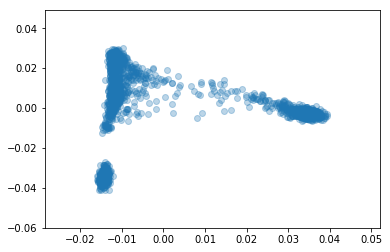

In [50]:
# Plot first two principal components
x = eigenvecs['PC1']
y = eigenvecs['PC2']
plt.scatter(x,y,alpha=0.3)

In [19]:
# load pop data
pop = pd.read_table('integrated_call_samples_v3.20130502.ALL.panel', usecols=[0,1,2,3])
pop.head()

,sample,pop,super_pop,gender
0,HG00096,GBR,EUR,male
1,HG00097,GBR,EUR,female
2,HG00099,GBR,EUR,female
3,HG00100,GBR,EUR,female
4,HG00101,GBR,EUR,male


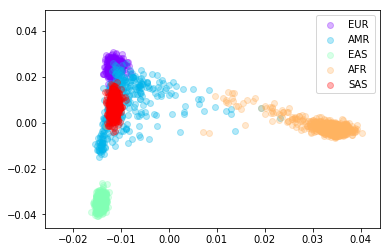

In [25]:
# plot first two PCs
fig = plt.figure()
ax = fig.add_subplot(111)

# generate colormap for super pops
colors=cm.rainbow(np.linspace(0,1,len(set(pop['super_pop']))))

# plot (PC1,PC2) for each individual in each super pop
for p, col in zip(set(pop['super_pop']),colors):
    inds = pop[pop['super_pop']==p]['sample']
    pc1 = eigenvecs[eigenvecs['FID'].isin(inds)]['PC1']
    pc2 = eigenvecs[eigenvecs['FID'].isin(inds)]['PC2']
    ax.scatter(pc1,pc2, c = col, alpha=0.3, label = p)
    
ax.legend()

You can see that the five populations cluster neatly. There is some overlap between EUR (Europeans) and AMR (Ad Mixed American). This is not unexpected for mixed ancestry individuals from America. There is also a sort of merge betwen Africans AFR (Africans) and AMR. This is also not unexpected, and is indicative of mixed ancestry as well. <br>

More interestingly, the SAS (South Asian) super population completely overlaps the AMR super population. Let's a take a closer look at what populations comprise these super populations.

In [42]:
sas_pops = pop[pop['super_pop']=='SAS']['pop']
amr_pops = pop[pop['super_pop']=='AMR']['pop']
print('SAS populations: %s \nAMR populations: %s' % (', '.join(set(sas_pops)), ', '.join(set(amr_pops))))


SAS populations: ITU, BEB, PJL, STU, GIH 
AMR populations: MXL, PEL, CLM, PUR


| Population code | Population | Super-population code|
| - | - | - |
| ITU | Indian Telugu from the UK | SAS |
| BEB | Bengali from Bangladesh | SAS |
| PJL | Bengali from Bangladesh | SAS |
| STU | Sri Lankan Tamil from the UK | SAS |
| GIH | Gujarati Indian from Houston, Texas	| SAS |
| MXL | Mexican Ancestry from Los Angeles, USA | AMR |
| PEL | Peruvians from Lima, Peru | AMR | 
| CLM | Colombians from Medellin, Colombia | AMR |
| PUR | Puerto Ricans from Puerto Rico | AMR |

What do you think accounts for this large overlap? <br>